# A Sampling Of Monte Carlo Methods

This notebook is an introduction to Monte Carlo methods.  Monte Carlo methods are a class of techniques that use random sampling to simulate a draw from some distribution.  By making repeated draws and calculating an aggregate on the distribution of those draws, it's possible to approximate a solution to a problem that may be very hard to calculate directly.

Below we'll explore several examples of using Monte Carlo methods to model a domain and attempt to answer a question.  These examples are intentionally basic.  They're designed to illustrate the core concept without getting lost in problem-specific details.  Consider these a starting point for learning how to apply Monte Carlo more broadly.

One key point that's worth stating - Monte Carlo methods are an <b>approach</b>, not an algorithm.  This was confusing to me at first.  I kept looking for a "Monte Carlo" python library that implemented everything for me like scikit-learn does.  There isn't one.  It's a way of thinking about a problem, similar to dynamic programming.  Each problem is different.  There may be some patterns but they have to be learned over time.  It isn't something that can be abstracted into a library.

The application of Monte Carlo methods tends to follow a pattern.  There are four general steps, and you'll see below that the problems we tackle pretty much adhere to this formula.

1) Create a model of the domain<br>
2) Generate random draws from the distribution over the domain<br>
3) Perform some deterministic calculation on the output<br>
4) Aggregate the results<br>

This sequence informs us about the type of problems where the general application of Monte Carlo methods is useful.  Specifically, when we have some <b>generative model</b> of a domain (i.e. something that we can use to generate data points from at will) and want to ask a question about that domain that isn't easily answered directly, we can use Monte Carlo to get the answer instead.

To start off, let's tackle one of the simplest domains there is - rolling a pair of dice.  This is very straightforward to implement.

In [1]:
%matplotlib inline
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

def roll_die():
    return random.randint(1, 6)


def roll_dice():
    return roll_die() + roll_die()


print(roll_dice())
print(roll_dice())
print(roll_dice())

9
8
9


/home/john/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Think of the dice as a probability distribution.  On any given roll, there's some likelihood of getting each possible number.  Collectively, these probabilites represent the distribution for the dice-rolling domain.  Now imagine you want to know what this distribution looks like, having only the knowledge that you have two dice and each one can roll a 1-6 with equal probability.  How would you calculate this distribution analytically?  It's not obvious, even for the simplest of domains.  Fortunately there's an easy way to figure it out - just roll the dice over and over, and count how many times you get each combination!

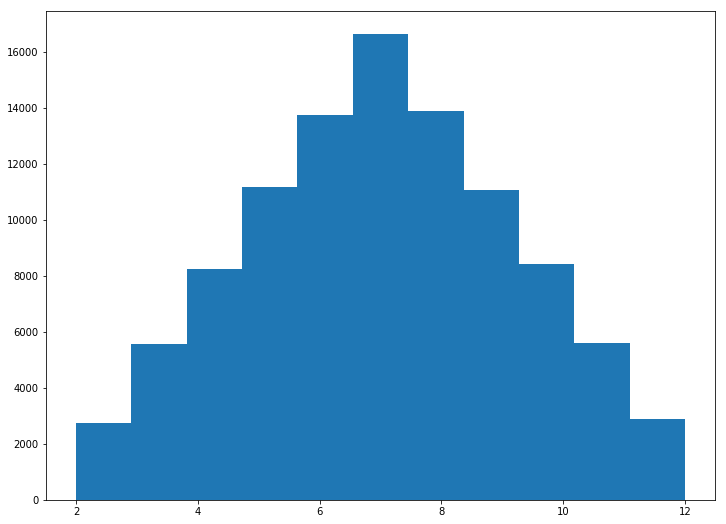

In [2]:
def roll_histogram(samples):
    rolls = []
    for _ in range(samples):
        rolls.append(roll_dice())

    fig, ax = plt.subplots(figsize=(12, 9))
    plt.hist(rolls, bins=11)


roll_histogram(100000)

The histogram gives us a visual sense of the likelihood of each roll, but what if we want something more targeted?  Say, for example, that we wanted to know the probability of rolling a 6 or higher?  Again, consider how you would solve this with an equation.  It's not easy, right?  But with a few very simple lines of code we can write a function that makes this question trivial.

In [3]:
def prob_of_roll_greater_than_equal_to(x, n_samples):
    geq = 0
    for _ in range(n_samples):
        if roll_dice() >= x:
            geq += 1

    probability = float(geq) / n_samples
    print('Probability of rolling greater than or equal to {0}: {1} ({2} samples)'.format(x, probability, n_samples))

All we're doing is running a loop some number of times and rolling the dice, then recording if the result is greater than or equal to some number of interest.  At the end we calculate the proportion of samples that matched our critera, and we have the probability we're interested in.  Easy!

You might notice that there's a parameter for the number of samples to draw.  This is one of the tricky parts of Monte Carlo.  We're relying on the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) to get an accurate result, but how large is large enough?  In practice it seems you just have to tinker with the number of samples and see where the result begins to stabilize (think of it as a hyperparameter that can be tuned).

To make this more concrete, let's try calculating the probability of a 6 or higher with varying numbers of samples.

In [4]:
prob_of_roll_greater_than_equal_to(6, n_samples=10)
prob_of_roll_greater_than_equal_to(6, n_samples=100)
prob_of_roll_greater_than_equal_to(6, n_samples=1000)
prob_of_roll_greater_than_equal_to(6, n_samples=10000)
prob_of_roll_greater_than_equal_to(6, n_samples=100000)
prob_of_roll_greater_than_equal_to(6, n_samples=1000000)

Probability of rolling greater than or equal to 6: 0.9 (10 samples)
Probability of rolling greater than or equal to 6: 0.68 (100 samples)
Probability of rolling greater than or equal to 6: 0.723 (1000 samples)
Probability of rolling greater than or equal to 6: 0.7217 (10000 samples)
Probability of rolling greater than or equal to 6: 0.72135 (100000 samples)
Probability of rolling greater than or equal to 6: 0.722335 (1000000 samples)


In this case 100 samples wasn't quite enough, but 1,000,000 was probably overkill.  This is going to vary depending on the problem though.

Let's move on to something slightly more complicated - calculating the value of pi.  If you're not aware, pi is the ratio of a circle's circumference to its diameter.  In other words, if you "un-rolled" a circle with a diameter of one you would get a line with a lenth of pi.  There are analytical ways to derive the value of pi, but what if we didn't know that?  What if all we knew was the definition above?  Monte Carlo to the rescue!

To understand the function below, imagine a unit circle inscribed in a unit square.  We know that the area of a unit circle is pi/4, so if we generate a bunch of points randomly in a unit square and record how many of them "hit" in the circle's area, the ratio of "hits" to "misses" should be equal to pi/4.  We then multiply by 4 to get an approximation of pi.  This works with a full circle as well as a quarter circle (which we'll use below).

In [5]:
def estimate_pi(samples):
    hits = 0
    for _ in range(samples):
        x = random.random()
        y = random.random()

        if math.sqrt((x ** 2) + (y ** 2)) < 1:
            hits += 1

    ratio = (float(hits) / samples) * 4
    print('Estimate with {0} samples: {1}'.format(samples, ratio))

Let's try it out with varying numbers of samples and see what we get.

In [6]:
estimate_pi(samples=10)
estimate_pi(samples=100)
estimate_pi(samples=1000)
estimate_pi(samples=10000)
estimate_pi(samples=100000)
estimate_pi(samples=1000000)

Estimate with 10 samples: 3.2
Estimate with 100 samples: 3.12
Estimate with 1000 samples: 3.172
Estimate with 10000 samples: 3.1352
Estimate with 100000 samples: 3.14964
Estimate with 1000000 samples: 3.14116


We should observe that as we increase the number of samples, the result is converging on the value of pi.  If the logic I described above for how we're getting this result isn't clear, a picture might help.

In [7]:
def plot_pi_estimate(samples):
    hits = 0
    x_inside = []
    y_inside = []
    x_outside = []
    y_outside = []

    for _ in range(samples):
        x = random.random()
        y = random.random()

        if math.sqrt((x ** 2) + (y ** 2)) < 1:
            hits += 1
            x_inside.append(x)
            y_inside.append(y)
        else:
            x_outside.append(x)
            y_outside.append(y)

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_aspect('equal')
    ax.scatter(x_inside, y_inside, s=20, c='b')
    ax.scatter(x_outside, y_outside, s=20, c='r')
    fig.show()

    ratio = (float(hits) / samples) * 4
    print('Estimate with {0} samples: {1}'.format(samples, ratio))

This function will plot randomly-generated numbers with a color coding indicating if the point falls inside (blue) or outside (red) the area of the unit circle.  Let's try it with a moderate number of samples first and see what it looks like.

Estimate with 10000 samples: 3.1244


/home/john/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


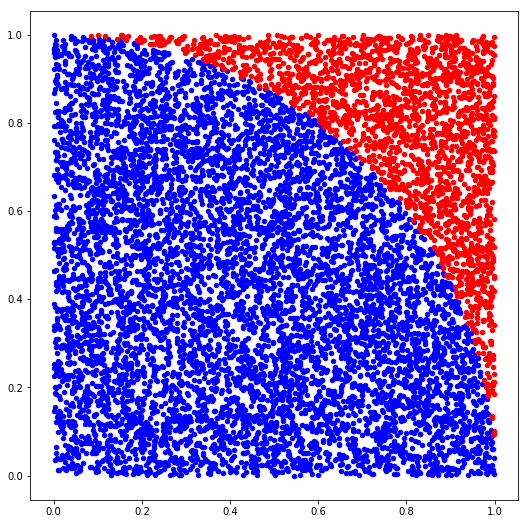

In [8]:
plot_pi_estimate(samples=10000)

We can more or less see the contours of the circle forming.  It should look much clearer if we raise the sample count a bit.

/home/john/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Estimate with 100000 samples: 3.1368


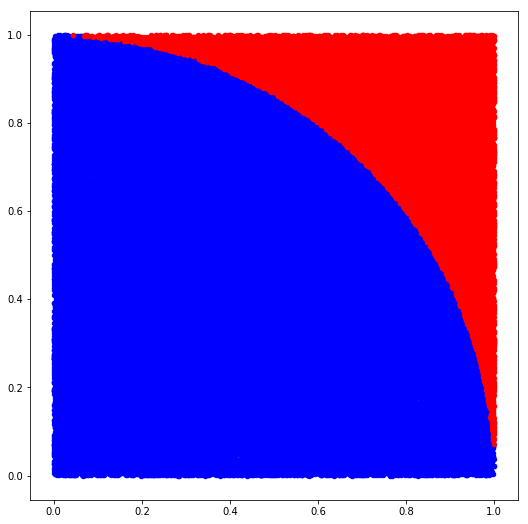

In [9]:
plot_pi_estimate(samples=100000)

Better!  It's worth taking a moment to consider what we're doing here.  After all, approximating pi (at least to a few decimal points) is a fairly trivial problem.  What's interesting about this technique though is we didn't need to know anything other than basic geometry to get there.  This concept generalizes to much harder problems where no other method of calcuating an answer is known to exist (or where doing so would be computationally intractable).  If sacrificing precision is an acceptable tradeoff, then using Monte Carlo techniques as a general problem-solving framework in domains involving randomness and uncertainty makes a lot of sense.

A related use of this technique involves combining Monte Carlo methods with Markov Chains, and is called (appropriately) Markov Chain Monte Carlo (usually abbreviated MCMC).  A full explanation of MCMC is well outside of our scope, but I encourage the reader to check out [this notebook](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb) for more information (side note: it's part of a whole series on Bayesian methods that is really good, and well worth your time).  In the interest of not adding required reading to understand the next part, I'll try to briefly summarize the idea behind MCMC.

Like general Monte Carlo methods, MCMC is fundamentally about sampling from a distribution.  But unlike before, MCMC is an approach to sampling an <b>unknown</b> distribution, given only some existing samples.  MCMC involves using a Markov chain to "search" the space of possible distributions in a guided way.  Rather than generating truly random samples, it uses the existing data as a starting point and then "walks" a Markov chain toward a state where the chain (hopefully) converges with the real posterior distribution (i.e. the same distribution that the original sample data came from).

In a sense, MCMC inverts what we saw above.  In the dice example, we began with a <b>distribution</b> and drew samples to answer some question about that distribution.  With MCMC, we <b>begin</b> with samples from some <b>unknown</b> distribution, and our objective is to approximate, as best we can, the distribution that those samples came from.  This way of thinking about it helps to clarify in what situations we need general Monte Carlo methods vs. MCMC.  If you already have the "source" distribution and need to answer some question about it, it's a Monte Carlo problem.  However, if all you have is some data but you don't know the "source", then MCMC can help you find it.

Let's see an example to make this more concrete.  Imagine we have the result of a series of coin flips and we want to know if the coin being used is unbiased (that is, equally likely to land on heads or tails).  How would you determine this from the data alone?  Let's generate a sequence of coin flips from a coin that we know to be biased so we have some data as a starting point. 

In [10]:
p_heads = 0.6

def biased_coin_flip():
    if random.random() <= p_heads:
        return 1
    else:
        return 0

n_trials = 100
coin_flips = [biased_coin_flip() for _ in range(n_trials)]
n_heads = sum(coin_flips)
print(n_heads)

60


In this case since we're producing the data ourselves we know it is biased, but imagine we didn't know where this data came from.  All we know is we have 100 coin flips and 60 are heads.  Obviously 60 is greater than 50, which is what we would guess if the coin was fair.  On the other hand, it's definitely possible to get 60/100 heads with a fair coin just due to randomness.  How do we move from a point estimate to a distribution of the likelihood that the coin is fair?  That's where MCMC comes in.

In [11]:
with pm.Model() as coin_model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p, observed=coin_flips)
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step)
    trace = trace[5000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p_interval__]
100%|██████████| 100500/100500 [00:08<00:00, 11182.36it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '15887' (I am process '15888')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/john/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15887' (I am process '15889')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/john/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15888' (I am process '15889')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/john/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
The number of effective samples is smaller than 25% 

Understanding this code requires some background in Bayesian statistics as well as PyMC3.  Very simply, we define a prior distrbution (p) along with an observed variable (obs) representing our known data.  We then configure the algorithm to use (Metropolis-Hastings) and initiate the chain.  The result is a sequence of values that should, in aggregate, represent the most likely distribution that characterizes the original data.

To see what we ended up with, we can plot the values in a histogram.

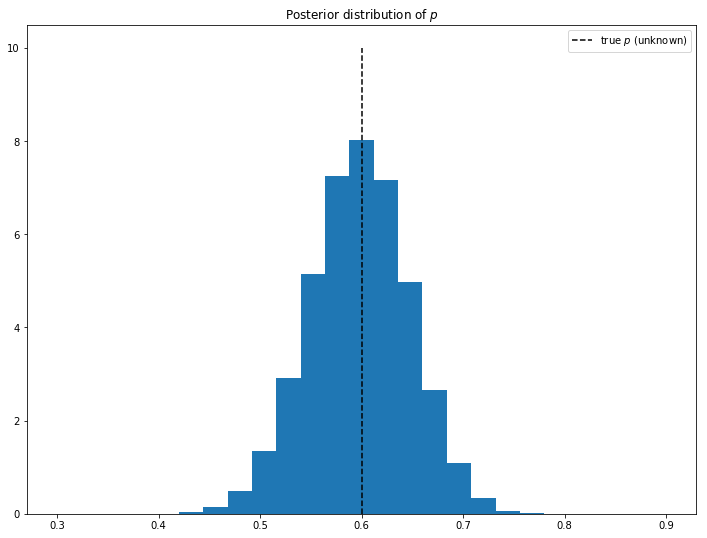

In [12]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.title('Posterior distribution of $p$')
plt.vlines(p_heads, 0, n_trials / 10, linestyle='--', label='true $p$ (unknown)')
plt.hist(trace['p'], range=[0.3, 0.9], bins=25, histtype='stepfilled', normed=True)
plt.legend()

From this result, we can see that the overwhelming likelihood is that the coin is biased.  To actually derive a concrete probability estimate though, we need to specify a range for which we would consider the result "fair" and integrate over the probability density function (basically the histogram above).  For the sake of argument, let's say that anything between .45-.55 is fair.  We can then compute the result using a simple count.

In [13]:
n_fair = len(np.where((trace['p'] >= 0.45) & (trace['p'] < 0.55))[0])
n_total = len(trace['p'])

print(float(n_fair / n_total))

0.16254736842105263


By our definition above, there's roughly a 16% chance that the coin is unbiased!  Hopefully this provides a good illustration of the power and usefulness of MCMC, and Monte Carlo methods more generally.